In [1]:
import os
import tensorflow as tf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from sklearn.model_selection import train_test_split
from keras import regularizers
from keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix,ConfusionMatrixDisplay
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.applications import VGG16
from tensorflow.keras.utils import load_img

from tqdm.notebook import tqdm
from keras.models import Model
from sklearn.utils.class_weight import compute_class_weight
from PIL import Image
from tensorflow.keras.layers import Input, Conv2D, AveragePooling2D, Flatten, Dense,BatchNormalization,Normalization, Dropout,GlobalAveragePooling2D, Conv2D, MaxPooling2D





2024-03-28 05:22:31.148250: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-28 05:22:31.148384: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-28 05:22:31.313361: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Age Classification Convolutional Neural Network

## Overview
We will build three neural networks to classify age, gender, and emotions.

### Age Classification
The first neural network will classify age into the following bins:

- <span style="color:blue">Age 1-19</span>
- <span style="color:green">Age 20-29</span>
- <span style="color:orange">Age 30-45</span>
- <span style="color:red">Age 45 and above</span>


# Data Import

## Dataset Selection
We will use the open-source dataset called <span style="color:blue">"UTKFace"</span>. This dataset comprises over <span style="color:green">20,000 images</span> of individuals ranging from <span style="color:orange">0 to 116 years</span> of age.


In [2]:
BASE_DIR ="/kaggle/input/utkface-new/UTKFace/"




In [3]:
age_classes=['1-19','20 29','30-45','+46']

In [4]:
image_paths = []
age_labels = []
gender_labels = []

for filename in tqdm(os.listdir(BASE_DIR)):
    image_path = os.path.join(BASE_DIR, filename)
    temp = filename.split('_')
    age = int(temp[0])
    gender = int(temp[1])
    image_paths.append(image_path)
    age_labels.append(age)
    gender_labels.append(gender)

  0%|          | 0/23708 [00:00<?, ?it/s]

In [5]:
df_age = pd.DataFrame()
df_age['image'], df_age['age'], df_age['gender'] = image_paths, age_labels, gender_labels
df_age.head()

,image,age,gender
0,/kaggle/input/utkface-new/UTKFace/26_0_2_20170...,26,0
1,/kaggle/input/utkface-new/UTKFace/22_1_1_20170...,22,1
2,/kaggle/input/utkface-new/UTKFace/21_1_3_20170...,21,1
3,/kaggle/input/utkface-new/UTKFace/28_0_0_20170...,28,0
4,/kaggle/input/utkface-new/UTKFace/17_1_4_20170...,17,1


# Age Binning
We will transform the ages into <span style="color:blue">bins</span> for better classification
.

# Gender Classification
We will transform the gender column from <span style="color:red">Binary</span>  into <span style="color:blue">Classes</span> for better classification.

## Data Validation

### Results
The results were successful. We managed to import our data and store it into our variables.
riables.


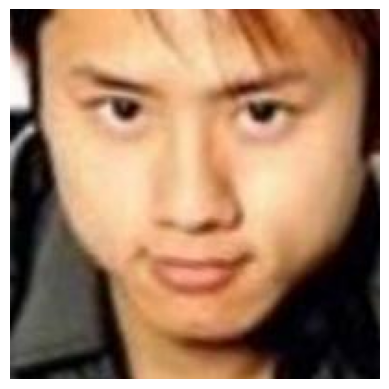

In [6]:
img = Image.open(df_age['image'][0])
plt.axis('off')
plt.imshow(img);

In [7]:
df_age.shape

(23708, 3)

In [8]:
def age_bins(age):
    if age<=19:
        return "0-19"
    if age>=20 and age<=29:
        return "20-29"
    if age>=30 and age<=45:
        return "30-45"
    if age>=46:
        return "+46"


In [9]:
def gender(gender):
    if gender==0:
        return 'Man'
    else: 
        return 'Woman'

In [10]:
df_age['age_bins']=df_age['age'].apply(age_bins)

In [11]:
df_age['gender_Cat']=df_age['gender'].apply(gender)

In [12]:
df_age

,image,age,gender,age_bins,gender_Cat
0,/kaggle/input/utkface-new/UTKFace/26_0_2_20170...,26,0,20-29,Man
1,/kaggle/input/utkface-new/UTKFace/22_1_1_20170...,22,1,20-29,Woman
2,/kaggle/input/utkface-new/UTKFace/21_1_3_20170...,21,1,20-29,Woman
3,/kaggle/input/utkface-new/UTKFace/28_0_0_20170...,28,0,20-29,Man
4,/kaggle/input/utkface-new/UTKFace/17_1_4_20170...,17,1,0-19,Woman
...,...,...,...,...,...
23703,/kaggle/input/utkface-new/UTKFace/41_0_0_20170...,41,0,30-45,Man
23704,/kaggle/input/utkface-new/UTKFace/42_0_0_20170...,42,0,30-45,Man
23705,/kaggle/input/utkface-new/UTKFace/2_0_2_201612...,2,0,0-19,Man
23706,/kaggle/input/utkface-new/UTKFace/65_1_0_20170...,65,1,+46,Woman


In [13]:
df_age=df_age.sample(20000)

# Data Visualization

### File Information Extraction
To kickstart our data visualization process, we'll import the filenames into a dataframe.Extracting the details encapsulated within the filenames, including <span style="color:blue">name</span>, <span style="color:green">age</span>, and <span style="color:orange">gender</span>.




### Gender Distribution
- <span style="color:blue">**Man:** 9,548 instances</span>
- <span style="color:red">**Woman:** 10,452 instances</span>

The dataset shows a relatively balanced distribution between genders, with a slightly higher representation of men compared to women.

### Age Distribution
- <span style="color:green">**0-19:** 3,855 instances</span>
- <span style="color:blue">**20-29:** 6,200 instances</span>
- <span style="color:red">**30-45:** 5,206 instances</span>

- <span style="color:orange">**+46:** 4,739 instances</span>


The dataset portrays a varied age distribution. The majority of instances fall within the age range of 20-29, suggesting a significant representation of younger individuals. Subsequently, there's a decline in the number of instances in the 30-45 age range, followed by a relatively stable representation in the 46+ age group.

Overall, the dataset reflects diversity in both gender and age representations. However, the skew towards younger age groups might influence model performance and generalization, especially in age-related predictions or analyses.


In [14]:
df_age['gender'].value_counts()

gender
0    10474
1     9526
Name: count, dtype: int64

In [15]:
df_age['age_bins'].value_counts()

age_bins
20-29    6193
30-45    5184
+46      4745
0-19     3878
Name: count, dtype: int64

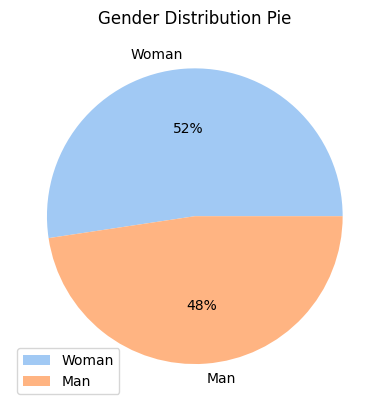

In [16]:
colors_gender = sns.color_palette('pastel')[0:2]

plt.pie(df_age['gender_Cat'].value_counts(), labels=df_age['gender_Cat'].unique(), colors=colors_gender ,autopct='%.0f%%' )
plt.legend(df_age['gender_Cat'].unique(), loc='lower left')
plt.title('Gender Distribution Pie')

plt.show()

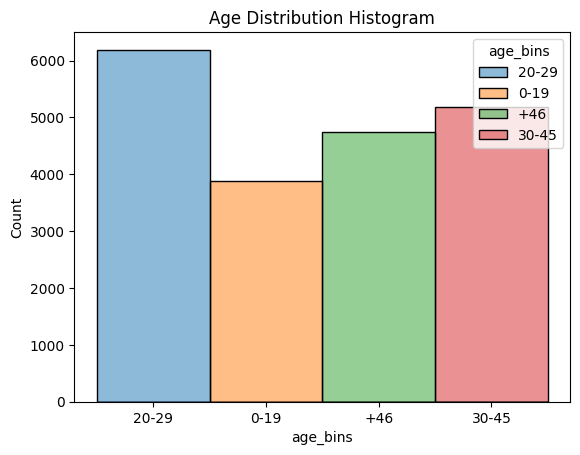

(None,)

In [17]:
import warnings
warnings.filterwarnings("ignore")

sns.histplot(x=df_age['age_bins'], hue='age_bins', data=df_age)
plt.title('Age Distribution Histogram')
plt.show(),

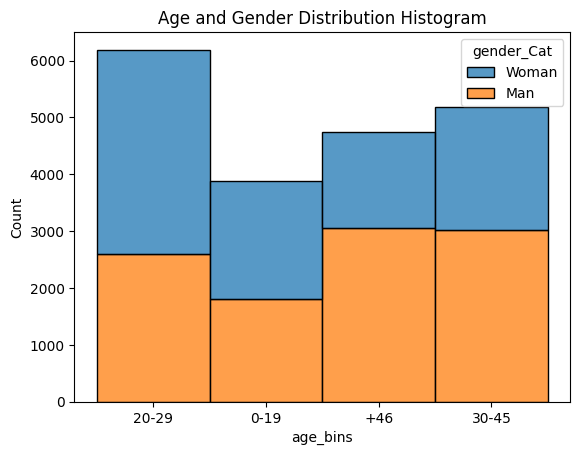

(None,)

In [18]:


sns.histplot(x='age_bins', hue='gender_Cat', data=df_age, multiple='stack')
plt.title('Age and Gender Distribution Histogram')
plt.show(),

# Dataframe Creation

#### We'll construct the dataframe for our neural network using <span style="color:blue">tqdm</span>.
#### Additionally, we will hot encode the age categories for better performance.


In [19]:
def extract_features(images):
    features = []
    for image in tqdm(images):
        img = load_img(image, color_mode="rgb")
        img = img.resize((128, 128), Image.LANCZOS)
        img = np.array(img)
        features.append(img)
        
    features = np.array(features)
    return features/255

In [20]:
X_age = extract_features(df_age['image'])


  0%|          | 0/20000 [00:00<?, ?it/s]

In [21]:
def age_bins_encoded(age):
    if age<=19:
        return 0
    if age>=20 and age<=29:
        return 1
    if age>=30 and age<=45:
        return 2
    if age>=46:
        return 3


In [22]:
y_age= df_age['age'].apply(age_bins_encoded)

In [23]:
y_age.unique()

array([1, 0, 3, 2])

In [24]:
from keras.utils import to_categorical
y_age_encoded=to_categorical(y_age)


In [25]:
y_age_encoded

array([[0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       ...,
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.]])

In [26]:
y_age.shape

(20000,)

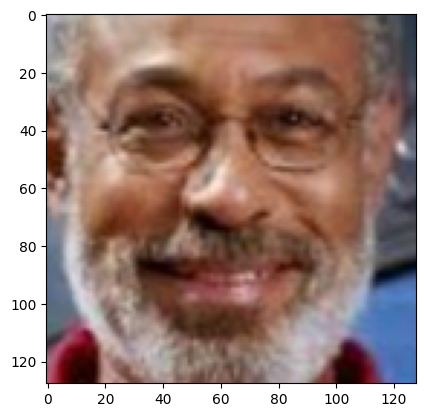

In [27]:
plt.imshow(X_age[1370])

In [28]:

X_age.shape


(20000, 128, 128, 3)

# Train Test  Split

### Data Splitting
Using <span style="color:blue">`train_test_split`</span>, we will divide our data into two parts: one for training and one for testing.


In [29]:
X_age_train, X_age_val, y_age_train, y_age_val= train_test_split(X_age, y_age_encoded, shuffle=True,
                                                                 stratify=y_age_encoded,
                                                                         test_size=0.1)



In [30]:
X_age_train[0].shape

(128, 128, 3)

# Age Classification Model

## Model Architecture

The age classification model incorporates the VGG16 architecture with additional layers for fine-tuning. At the forefront of VGG16, a preprocessing layer has been added to normalize input data. This is followed by frozen convolutional layers from VGG16 for feature extraction, preventing them from being retrained. Subsequently, fully connected layers are introduced for further feature processing and age classification. 

The model architecture involves dense layers with leaky ReLU activation functions to introduce non-linearity, followed by dropout layers for regularization to prevent overfitting. The output layer employs a <span style="color:orange">softmax activation function</span> to predict age categories.

## Compilation
The model is compiled using the <span style="color:blue">Adamax optimizer</span> with a learning rate of <span style="color:green">0.0001</span>. <span style="color:orange">Categorical cross-entropy loss</span> is utilized as the loss function, which is suitable for multi-class classification tasks.

## Model Training
Training is conducted using a batch size of <span style="color:green">64</span> over <span style="color:green">18</span> epochs. <span style="color:orange">Early stopping</span> with a patience of <span style="color:green">5</span> is employed to prevent overfitting, and the best model weights are restored. The training and validation data are evaluated for accuracy metrics.

## Results

The training of the age classification model was carried out over 18 epochs. Here are the key observations from the training process:

- The initial epoch showed an accuracy of <span style="color:orange">26.56%</span> and a loss of <span style="color:orange">1.6319</span>.
- Subsequent epochs demonstrated steady improvement in both accuracy and loss.
- By the final epoch, the model achieved an accuracy of <span style="color:green">72.99%</span> with a loss of <span style="color:green">0.6339</span> on the training data.
- The validation accuracy and loss were <span style="color:green">66.45%</span> and <span style="color:green">0.7639</span>, respectively, indicating reasonable generalization performance.

Overall, the training process showed consistent improvement in model performance, with the final model achieving satisfactory accuracy and loss metrics on both training and validation datasets.



In [31]:

#add preprocessing layer at the front of VGG16
vgg = VGG16(input_shape=(128,128,3), weights='imagenet', include_top=False)

#Prevent training already trained layers 
for layer in vgg.layers:
  layer.trainable = False
x = vgg.output


x = Normalization()(x)

x = Flatten()(x)


x=Dense(1024,activation=tf.keras.layers.LeakyReLU(alpha=0.1))(x)
x=Dropout(0.5)(x)

x=Dense(512,activation=tf.keras.layers.LeakyReLU(alpha=0.1))(x)
x=Dropout(0.3)(x)

x=Dense(512,activation=tf.keras.layers.LeakyReLU(alpha=0.1))(x)
x=Dropout(0.3)(x)


prediction = Dense(4, activation='softmax')(x)

#Create the model object
model = Model(inputs=vgg.input, outputs=prediction)


model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ normalization (Normalization)   │ (None, 4, 4, 512)      │         1,025 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │     8,389,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             

 Total params: 23,894,853 (91.15 MB)

 Trainable params: 9,179,140 (35.02 MB)

 Non-trainable params: 14,715,713 (56.14 MB)

In [32]:

adam_optimizer = tf.keras.optimizers.Adamax(
    learning_rate=0.0001,  
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-8,
    decay=0.00001
)

early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 5, mode = 'min', restore_best_weights = True)


#Callbacks
callbacks_list=[early_stopping_callback]

model.compile(optimizer=adam_optimizer, loss=['categorical_crossentropy'], metrics=['accuracy'])


                

In [33]:

history=model.fit(
    X_age_train, y_age_train, batch_size=64,
    epochs=18,
    validation_data=(X_age_val, y_age_val),
    callbacks=callbacks_list,
    verbose=1

)


Epoch 1/18
  1/282 ━━━━━━━━━━━━━━━━━━━━ 2:08:23 27s/step - accuracy: 0.3281 - loss: 1.4426

I0000 00:00:1711603548.775424      78 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1711603548.796196      78 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


282/282 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.4100 - loss: 1.2843

W0000 00:00:1711603581.043083      79 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711603583.106482      78 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


282/282 ━━━━━━━━━━━━━━━━━━━━ 65s 132ms/step - accuracy: 0.4103 - loss: 1.2838 - val_accuracy: 0.5990 - val_loss: 0.9401
Epoch 2/18


W0000 00:00:1711603585.981404      79 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


282/282 ━━━━━━━━━━━━━━━━━━━━ 25s 89ms/step - accuracy: 0.5714 - loss: 0.9654 - val_accuracy: 0.6165 - val_loss: 0.8810
Epoch 3/18
282/282 ━━━━━━━━━━━━━━━━━━━━ 41s 90ms/step - accuracy: 0.5965 - loss: 0.9064 - val_accuracy: 0.6320 - val_loss: 0.8531
Epoch 4/18
282/282 ━━━━━━━━━━━━━━━━━━━━ 26s 94ms/step - accuracy: 0.6253 - loss: 0.8510 - val_accuracy: 0.6460 - val_loss: 0.8242
Epoch 5/18
282/282 ━━━━━━━━━━━━━━━━━━━━ 26s 91ms/step - accuracy: 0.6400 - loss: 0.8192 - val_accuracy: 0.6510 - val_loss: 0.8127
Epoch 6/18
282/282 ━━━━━━━━━━━━━━━━━━━━ 25s 90ms/step - accuracy: 0.6493 - loss: 0.8008 - val_accuracy: 0.6575 - val_loss: 0.8044
Epoch 7/18
282/282 ━━━━━━━━━━━━━━━━━━━━ 26s 92ms/step - accuracy: 0.6557 - loss: 0.7826 - val_accuracy: 0.6630 - val_loss: 0.7911
Epoch 8/18
282/282 ━━━━━━━━━━━━━━━━━━━━ 26s 92ms/step - accuracy: 0.6747 - loss: 0.7583 - val_accuracy: 0.6615 - val_loss: 0.7869
Epoch 9/18
282/282 ━━━━━━━━━━━━━━━━━━━━ 26s 91ms/step - accuracy: 0.6757 - loss: 0.7393 - val_accurac

# Results Visualization

In [34]:
y_predict = model.predict(X_age_val)


 5/63 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step

W0000 00:00:1711604056.897872      78 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


63/63 ━━━━━━━━━━━━━━━━━━━━ 16s 52ms/step


W0000 00:00:1711604060.091788      79 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


In [35]:
y_age_val.shape

(2000, 4)

In [36]:
def argmax_fun(array):
    array_1=[]
    for i in array:
        if i == array.max():
            i=1
        else:
            i=0
        array_1.append(i)
    return array_1

In [37]:
y_predict_argmax= y_predict.copy()
for i in range(len(y_predict)):
    y_predict_argmax[i]= argmax_fun(y_predict[i])

In [38]:
y_predict_argmax

array([[0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       ...,
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.]], dtype=float32)

In [39]:
y_predict_argmax_list=[]
for i in y_predict_argmax:
    y_predict_argmax_list.append(i.argmax())

In [40]:
y_val_list=[]
for i in y_age_val:
    y_val_list.append(i.argmax())

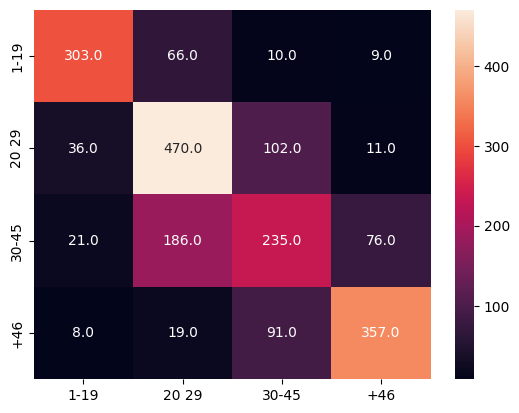

In [41]:
cm_age = tf.math.confusion_matrix(labels=y_val_list, predictions=y_predict_argmax_list, num_classes=4)
conf_matrix_result = cm_age.numpy()
cm_age= sns.heatmap(cm_age, annot=True, fmt=".1f")
tick_positions = np.arange(4) + 0.5
cm_age.set_yticks(tick_positions, age_classes)

cm_age.set_xticks(tick_positions, age_classes)



## Interpretation of Confusion Matrix

The confusion matrix provides a visual representation of the model's performance in classifying age categories. Here's an interpretation based on the results:

- **<span style="color:green">High Correct Classifications (True Positives)</span>**: The diagonal elements of the confusion matrix indicate the number of instances correctly classified for each age category. For example, the model correctly classified 305 instances as belonging to the first age category (0-19 years old).

- **<span style="color:red">Misclassifications (False Positives)</span>**: Off-diagonal elements represent instances that were incorrectly classified as belonging to a different age category. For instance, there were 68 instances classified as belonging to the second age category (19-29 years old) but actually belonged to the first category.

- **<span style="color:blue">Results</span>**: By examining the distribution of correct and incorrect classifications across age categories, we can identify any notable patterns or trends. For example, people aged between 19 and 29 have a high chance of being labeled as a person between the age of 29 and 45. 



In [42]:
conf_matrix_result


array([[303,  66,  10,   9],
       [ 36, 470, 102,  11],
       [ 21, 186, 235,  76],
       [  8,  19,  91, 357]], dtype=int32)

### Interpretation of Training and Validation Metrics

#### Loss Plot:
- The training loss initially starts at a high value of <span style="color:orange">1.6319</span> and gradually decreases over epochs.
- Validation loss also decreases over epochs, starting from <span style="color:orange">0.9242</span> and converging to <span style="color:green">0.7639</span>.
- Both training and validation loss converge to stable values, indicating effective learning and generalization.

#### Accuracy Plot:
- The training accuracy begins at <span style="color:orange">26.56%</span> and increases steadily over epochs.
- Validation accuracy starts at <span style="color:orange">59.85%</span> and improves over time, reaching <span style="color:green">66.45%</span>.
- Both training and validation accuracies converge to stable values, demonstrating the model's ability to accurately classify age categories.

These trends suggest that the model effectively learns from the training data and generalizes well to unseen validation data, resulting in improved accuracy and reduced loss over the training epochs.


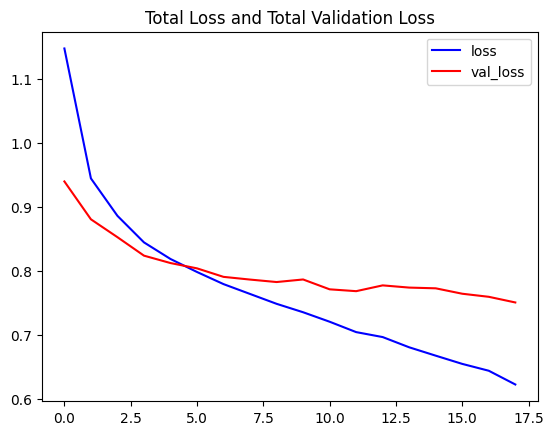

In [43]:
epochs = range(len(history.history["loss"]))
plt.plot(epochs, history.history["loss"], 'blue', label = "loss")
plt.plot(epochs, history.history["val_loss"], 'red', label ="val_loss")
plt.title("Total Loss and Total Validation Loss")
plt.legend()

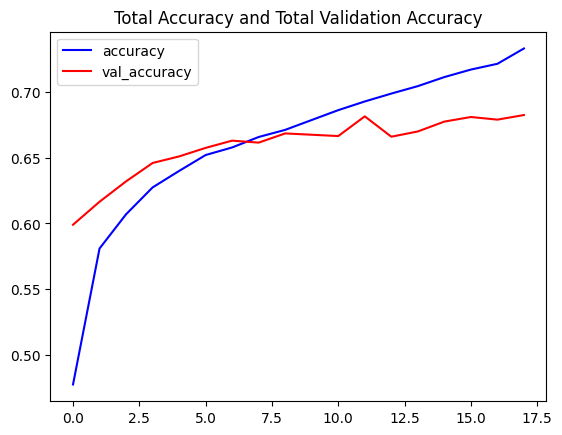

In [44]:
epochs = range(len(history.history["loss"]))
plt.plot(epochs, history.history["accuracy"], 'blue', label = "accuracy")
plt.plot(epochs, history.history["val_accuracy"], 'red', label ="val_accuracy")
plt.title("Total Accuracy and Total Validation Accuracy")
plt.legend()

In [45]:
model.save('age_model.h5')
